**In this demonstration we would test on a transformer model (from Chapter 11 of d2l.ai) how close to SOTA heuristics like ADAMW, does *a variant* the delta-GClip optimizer get - which was recently shown to be a (possible the only) step-length scheduling algorithm which provably converges on deep neural net losses, https://arxiv.org/abs/2404.08624. In this variant the norm of the gradient of the loss (based on which the modified clipping is done) is replaced by the norm of the partial derivative of the loss w.r.t the parameter being updated - thus effectively now we have different adaptive learning rates for each parameter of the model.**









#Installing d2l

In [1]:
!pip install d2l==1.0.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



#Setting Up The Transformer, Data and the Loss

The section numbers hyperlink to the corresponding sections in the book d2l.ai from which this setup is taken.

## Imports

In [3]:
import math
import torch
from torch import nn
from d2l import torch as d2l

##[11.3.2.1](https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html#masked-softmax-operation) Masked Softmax

In [4]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

##[11.3.3](https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html#scaled-dot-product-attention) Scaled Dot-product Attention

In [5]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

##[11.5.](https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html) Multi-headed Attention

In [6]:
class MultiHeadAttention(d2l.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        test = self.W_q(queries)
        # print(queries.shape)
        # print(test.shape)
        # print(test)
        queries = self.transpose_qkv(test)
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [7]:
@d2l.add_to_class(MultiHeadAttention)
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    print(X)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    # print (output)
    return output

@d2l.add_to_class(MultiHeadAttention)
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [8]:
class EasyMultiHeadAttention(d2l.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [9]:
@d2l.add_to_class(EasyMultiHeadAttention)
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    print(X)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    # print (output)
    return output

@d2l.add_to_class(MultiHeadAttention)
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [10]:
num_hiddens, num_heads = 20, 2
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.tensor([[[2, 0.737],[3.1, 3]],[[9, 3],[17, 0]]], dtype = torch.float32)
Y = torch.tensor([[[9, 3],[17, 0]],[[9, 3],[17, 0]]], dtype = torch.float32)
#attention(X, Y, Y, valid_lens)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


##[11.6.3](https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html#positional-encoding) Positional Encoding

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

##[11.7.2](https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#positionwise-feed-forward-networks) Positionwise-FFN

In [12]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

##[11.7.3](https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#residual-connection-and-layer-normalization) Add and Normalize

In [13]:
class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(Y + X)

In [14]:
embedding = nn.Embedding(15,7)
#embedding(torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]]))

##[11.7.4](https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#encoder) Encoder

In [15]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [16]:
class TransformerEncoder(d2l.Encoder):
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

##[11.7.5](https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#decoder) Decoder

In [17]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [18]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

#Defining Different Optimizers

Number of Training Data: $2048$

Number of Validation Data: $256$

Batch Size: $128$

In [19]:
def calculate_average_bleu(model, src, tgt, data):
    preds, _ = model.predict_step(
        data.build(src, tgt), d2l.try_gpu(), data.num_steps)

    total_bleu_score = 0
    for en, fr, p in zip(src, tgt, preds):
        translation = []
        for token in data.tgt_vocab.to_tokens(p):
            if token == '<eos>':
                break
            translation.append(token)
        total_bleu_score += d2l.bleu(" ".join(translation), fr, k=2)

    average_bleu_score = total_bleu_score / len(preds)
    return average_bleu_score

data = d2l.MTFraEng(batch_size=128, num_train=2048, num_val=256)
src, tgt = data._tokenize(data._preprocess(data._download()))
engs = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in src]
fras = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in tgt]

In [20]:
class MyTrainer(d2l.Trainer):
  def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0, num_trials=5):
        super().__init__(max_epochs=max_epochs, num_gpus=num_gpus, gradient_clip_val=gradient_clip_val)
        self.num_trials = num_trials
        self.all_train_losses = []
        self.all_val_losses = []

  def fit_epoch(self):
        self.model.train()
        total_train_loss = 0
        num_train_batches = 0
        for batch in self.train_dataloader:
            losstrain = self.model.training_step(self.prepare_batch(batch))
            total_train_loss += losstrain.item()
            num_train_batches += 1
            self.optim.zero_grad()
            with torch.no_grad():
                losstrain.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        average_train_loss = total_train_loss / num_train_batches
        self.train_losses.append(average_train_loss)
        if self.val_dataloader is None:
            return
        self.model.eval()
        total_val_loss = 0
        num_val_batches = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                lossval = self.model.validation_step(self.prepare_batch(batch))
                total_val_loss += lossval.item()
                num_val_batches += 1
            self.val_batch_idx += 1
        average_val_loss = total_val_loss / num_val_batches
        self.val_losses.append(average_val_loss)

  def fit(self, data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, modelname, lr):
    total_bleu_scores = 0
    for trial in range(self.num_trials):
        encoder = TransformerEncoder(
          len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout)
        decoder = TransformerDecoder(
          len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout)
        model = modelname(encoder, decoder, data.tgt_vocab['<pad>'],
                    lr)
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.train_losses = []
        self.val_losses = []
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
        self.all_train_losses.append(self.train_losses)
        self.all_val_losses.append(self.val_losses)
        total_bleu_scores += calculate_average_bleu(model, engs, fras, data)
    average_bleu_scores = total_bleu_scores/self.num_trials
    return model, average_bleu_scores

##delta-GClip

$h(\theta_t) = \eta \min\left\{1, \max\left\{\delta, \frac{\gamma}{\|g(\theta_t)\|}\right\}\right\}$

$\theta_{t+1} = \theta_t - h(\theta_t) \cdot g(\theta_t)$

In [21]:
import sys
sys.path.append('/content/drive/MyDrive/Collaborations/Procheta_Experiments/deltaGClip')

In [22]:
from torch.optim import Optimizer
from deltaGClip_c import *

data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)



class Seq2Seqdelta(d2l.Seq2Seq):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l

    def configure_optimizers(self):
        # SGD optimizer is used here
        return deltaGClip_c(self.parameters(), lr=0.5, delta=1e-06, gamma=1)


deltaGCliptrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=5)
deltaGClipmodel, deltaGClipbleu = deltaGCliptrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2Seqdelta, lr=0.5)

##ADAM

In [23]:
import time
import numpy as np
data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()



    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# Initialize trainer with multiple trials
ADAMtrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=5)
ADAMmodel, ADAMbleu = ADAMtrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2Seq, lr=0.001)

##ADAMW (with weight_decay = 0.01)

In [24]:
data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

class Seq2SeqADAMW(d2l.Seq2Seq):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l
    def configure_optimizers(self):
        # SGD optimizer is used here
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.01)

ADAMWtrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=5)
ADAMWmodel, ADAMWbleu = ADAMWtrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2SeqADAMW, lr=0.001)

##delta-GClip-c with delta = 0





In [25]:
from torch.optim import Optimizer
data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

class GClipOptimizer(Optimizer):
    def __init__(self, params, lr=0.1, delta=0, gamma=0.1):
        defaults = dict(lr=lr, delta=delta, gamma=gamma)
        super(GClipOptimizer, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        for group in self.param_groups:
            delta = group['delta']
            gamma = group['gamma']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                norm = grad.norm()
                if norm != 0 and not torch.isnan(norm):
                    g_norm = min(1,  (gamma / norm))
                    scaled_grad = g_norm * grad
                    p.data -= lr * scaled_grad

class Seq2SeqGClip(d2l.Seq2Seq):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l

    def configure_optimizers(self):
        # SGD optimizer is used here
        return GClipOptimizer(self.parameters(), lr=self.lr, delta=0, gamma=1)


GCliptrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=1)
GClipmodel, GClipbleu = GCliptrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2SeqGClip, lr=0.5)

##SGD

In [26]:
import time
data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
class Seq2SeqSGD(d2l.EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

SGDtrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=1)
SGDmodel, SGDbleu = SGDtrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2SeqSGD, lr=0.5)



#Comparative Plots : ADAM vs ADAMW vs deltaGClip-c

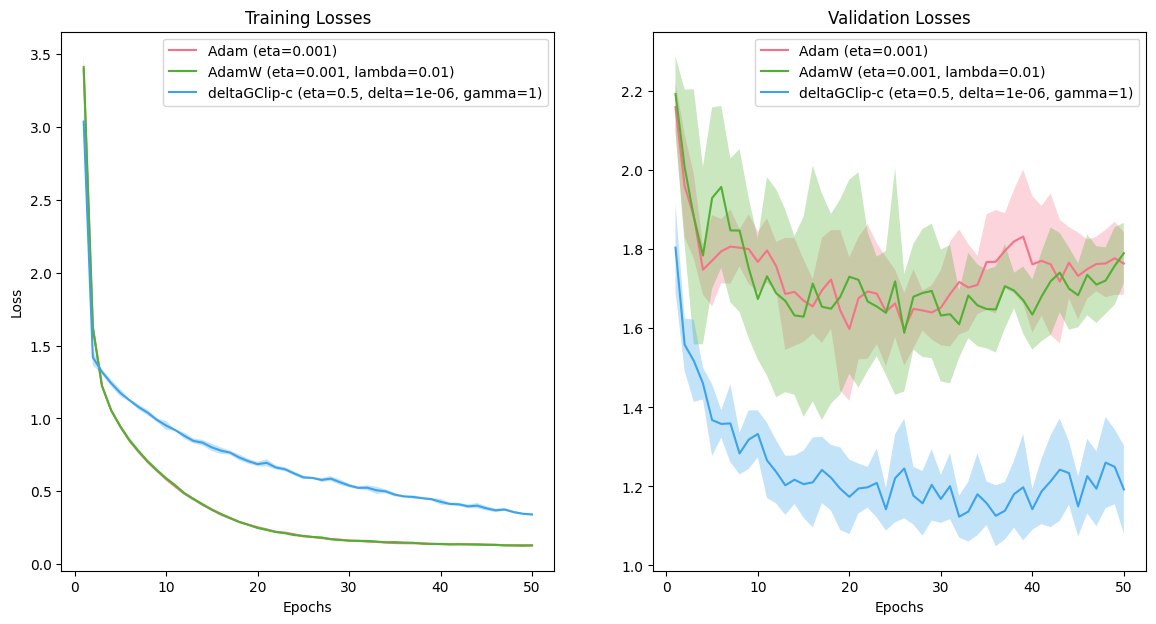

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_losses_with_shaded_errors(train_data, val_data, labels):
    epochs = range(1, len(train_data[0][0]) + 1)  # Assuming all data have the same number of epochs
    clrs = sns.color_palette("husl", len(labels))  # Generate distinct colors for each label

    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=False)

    # Plot training losses with shaded error bars
    for (train_mean, train_std), color, label in zip(train_data, clrs, labels):
        ax[0].plot(epochs, train_mean, label=label, color=color)
        ax[0].fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.3, facecolor=color)
    ax[0].set_title('Training Losses')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='upper right')

    # Plot validation losses with shaded error bars
    for (val_mean, val_std), color, label in zip(val_data, clrs, labels):
        ax[1].plot(epochs, val_mean, label=label, color=color)
        ax[1].fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.3, facecolor=color)
    ax[1].set_title('Validation Losses')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(loc='upper right')

    plt.show()

ADAM_train_losses_mean = np.mean(ADAMtrainer.all_train_losses, axis=0)
ADAM_train_losses_std = np.std(ADAMtrainer.all_train_losses, axis=0)
ADAM_val_losses_mean = np.mean(ADAMtrainer.all_val_losses, axis=0)
ADAM_val_losses_std = np.std(ADAMtrainer.all_val_losses, axis=0)

ADAMW_train_losses_mean = np.mean(ADAMWtrainer.all_train_losses, axis=0)
ADAMW_train_losses_std = np.std(ADAMWtrainer.all_train_losses, axis=0)
ADAMW_val_losses_mean = np.mean(ADAMWtrainer.all_val_losses, axis=0)
ADAMW_val_losses_std = np.std(ADAMWtrainer.all_val_losses, axis=0)

deltaGClip_train_losses_mean = np.mean(deltaGCliptrainer.all_train_losses, axis=0)
deltaGClip_train_losses_std = np.std(deltaGCliptrainer.all_train_losses, axis=0)
deltaGClip_val_losses_mean = np.mean(deltaGCliptrainer.all_val_losses, axis=0)
deltaGClip_val_losses_std = np.std(deltaGCliptrainer.all_val_losses, axis=0)

train_data = [
    (ADAM_train_losses_mean, ADAM_train_losses_std),
    (ADAMW_train_losses_mean, ADAMW_train_losses_std),
    (deltaGClip_train_losses_mean, deltaGClip_train_losses_std)
]
val_data = [
    (ADAM_val_losses_mean, ADAM_val_losses_std),
    (ADAMW_val_losses_mean, ADAMW_val_losses_std),
    (deltaGClip_val_losses_mean, deltaGClip_val_losses_std)
]

labels = ['Adam (eta=0.001)', 'AdamW (eta=0.001, lambda=0.01)', 'deltaGClip-c (eta=0.5, delta=1e-06, gamma=1)']

# Plot
plot_losses_with_shaded_errors(train_data, val_data, labels)

**Note: The $\eta$ chosen for ADAM and ADAMW are the ones found to be optimal for them as per our tests.**

#Comparative Plots : deltaGClip-c vs SGD vs deltaGClip-c (delta = 0)

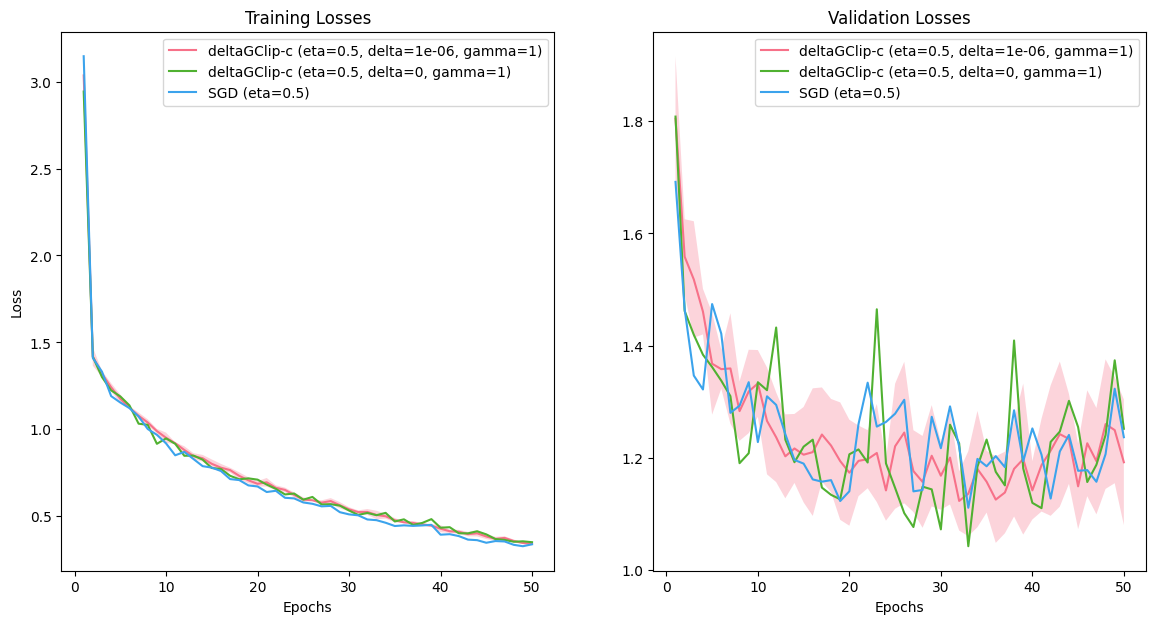

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_losses_with_shaded_errors(train_data, val_data, labels):
    epochs = range(1, len(train_data[0][0]) + 1)  # Assuming all data have the same number of epochs
    clrs = sns.color_palette("husl", len(labels))  # Generate distinct colors for each label

    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=False)

    # Plot training losses with shaded error bars
    for (train_mean, train_std), color, label in zip(train_data, clrs, labels):
        ax[0].plot(epochs, train_mean, label=label, color=color)
        ax[0].fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.3, facecolor=color)
    ax[0].set_title('Training Losses')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='upper right')

    # Plot validation losses with shaded error bars
    for (val_mean, val_std), color, label in zip(val_data, clrs, labels):
        ax[1].plot(epochs, val_mean, label=label, color=color)
        ax[1].fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.3, facecolor=color)
    ax[1].set_title('Validation Losses')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(loc='upper right')

    plt.show()


deltaGClip_train_losses_mean = np.mean(deltaGCliptrainer.all_train_losses, axis=0)
deltaGClip_train_losses_std = np.std(deltaGCliptrainer.all_train_losses, axis=0)
deltaGClip_val_losses_mean = np.mean(deltaGCliptrainer.all_val_losses, axis=0)
deltaGClip_val_losses_std = np.std(deltaGCliptrainer.all_val_losses, axis=0)

GClip_train_losses_mean = np.mean(GCliptrainer.all_train_losses, axis=0)
GClip_train_losses_std = np.std(GCliptrainer.all_train_losses, axis=0)
GClip_val_losses_mean = np.mean(GCliptrainer.all_val_losses, axis=0)
GClip_val_losses_std = np.std(GCliptrainer.all_val_losses, axis=0)

SGD_train_losses_mean = np.mean(SGDtrainer.all_train_losses, axis=0)
SGD_train_losses_std = np.std(SGDtrainer.all_train_losses, axis=0)
SGD_val_losses_mean = np.mean(SGDtrainer.all_val_losses, axis=0)
SGD_val_losses_std = np.std(SGDtrainer.all_val_losses, axis=0)

train_data = [
    (deltaGClip_train_losses_mean, deltaGClip_train_losses_std),
    (GClip_train_losses_mean, GClip_train_losses_std),
    (SGD_train_losses_mean, SGD_train_losses_std)
]
val_data = [
    (deltaGClip_val_losses_mean, deltaGClip_val_losses_std),
    (GClip_val_losses_mean, GClip_val_losses_std),
    (SGD_val_losses_mean, SGD_val_losses_std)
]

labels = ['deltaGClip-c (eta=0.5, delta=1e-06, gamma=1)', 'deltaGClip-c (eta=0.5, delta=0, gamma=1)', 'SGD (eta=0.5)']

# Plot
plot_losses_with_shaded_errors(train_data, val_data, labels)

#Comparing BLEU Scores Across Different Algorithms

In [29]:



src, tgt = data._tokenize(data._preprocess(data._download()))
engs = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in src]
fras = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in tgt]
preds, _ = ADAMmodel.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)


for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    #print(f'{en} => {translation}, bleu, {d2l.bleu(" ".join(translation), fr, k=2):.3f}')




In [30]:
src, tgt = data._tokenize(data._preprocess(data._download()))
engs = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in src]
fras = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in tgt]
preds, _ = ADAMmodel.predict_step(
#Change model here ^ model names = (ADAMWmodel, ADAMmodel, ADAM2model, deltaGClipmodel)
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)

total_bleu_score = 0

for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    total_bleu_score += d2l.bleu(" ".join(translation), fr, k=2)
average_bleu_score = total_bleu_score / len(preds)

# Print out the average BLEU score
#print(f'Average BLEU score: {average_bleu_score:.3f}')

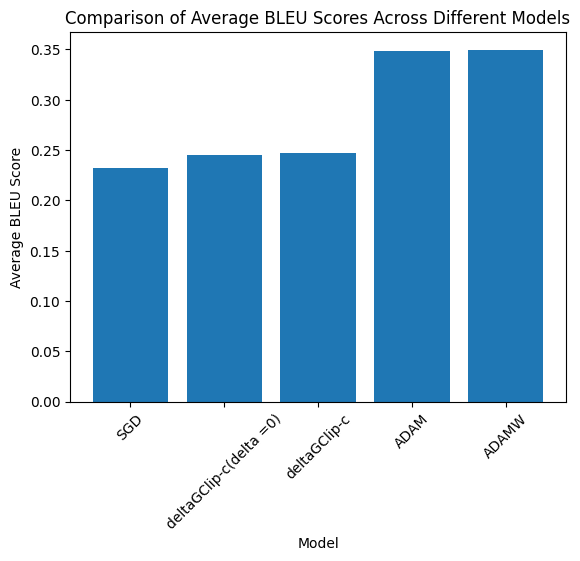

In [31]:
average_bleu_scores = {
    'SGD' : SGDbleu,
    'deltaGClip-c(delta =0)' : GClipbleu,
    'deltaGClip-c': deltaGClipbleu,
    'ADAM': ADAMbleu,
    'ADAMW': ADAMWbleu


}

# Plot the average BLEU scores
plt.bar(range(len(average_bleu_scores)), list(average_bleu_scores.values()), align='center')
plt.xticks(range(len(average_bleu_scores)), list(average_bleu_scores.keys()), rotation=45)
plt.xlabel('Model')
plt.ylabel('Average BLEU Score')
plt.title('Comparison of Average BLEU Scores Across Different Models')
plt.show()
